In [1]:
# Setup

# Characters are represented by 1-hot vectors of size 128
char_dim = 128

import numpy as np
import os
from collections import Counter
import unicodedata
import string
import gc
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import LSTM
from torch import optim

In [2]:
# replaces special characters with their close equivalents in order to simplify the characters that appear
def clean_text(text):
    return str(unicodedata.normalize('NFD', text).encode('ascii', 'ignore')).replace('\\n', '\n')

file = open('beatles.txt', 'r')
beatleslyrics = ''
# ignore lines that consist of 'TOP'
line = file.readline()
while line != '':
    beatleslyrics += line
    line = file.readline()
file.close()
beatleslyrics = clean_text(beatleslyrics)
print('read %d characters' % len(beatleslyrics))
char_counter = Counter(beatleslyrics)
print(char_counter)

for key in char_counter.keys():
    if ord(key) >= 128:
        print('invalid character value found: %s has numeric value %d', key, ord(key))

read 142942 characters
Counter({' ': 24384, 'e': 13002, 'o': 9898, 't': 8128, 'n': 7393, 'a': 7361, '\n': 5725, 'h': 5718, 'l': 5473, 'i': 5456, 's': 4862, 'r': 4848, 'y': 4260, 'd': 3771, 'u': 3528, 'm': 3125, 'g': 2673, 'w': 2581, ',': 2026, 'I': 1938, 'b': 1810, 'c': 1681, '.': 1438, 'k': 1382, 'v': 1269, 'f': 1256, 'p': 1085, "'": 985, 'T': 559, 'S': 492, 'A': 481, 'W': 409, 'O': 339, 'P': 296, 'B': 293, 'Y': 277, 'H': 236, '-': 228, 'L': 210, 'D': 208, 'M': 199, 'C': 161, 'N': 143, 'j': 137, 'G': 132, '(': 117, ')': 117, 'E': 107, 'R': 106, '?': 101, 'F': 95, 'z': 72, 'J': 69, 'x': 69, '!': 48, 'K': 46, 'U': 30, 'q': 18, '9': 15, ']': 12, 'V': 10, ';': 9, '[': 9, '0': 9, 'Q': 5, '1': 4, '5': 3, '"': 2, '2': 2, '3': 2, '4': 2, '7': 2, ':': 2, '/': 1, '6': 1, '8': 1})


In [3]:
# converts a list of N strings of length <=T into a numpy array of 1-hot vectors
# input: list of length N; max length of any string in the list is T
# output size: (T, N, 128)
i128 = np.eye(128)
def char_to_ix(texts):
    T = max([len(text) for text in texts])
    ords = np.zeros((T, len(texts)), dtype=int)
    for n, text in enumerate(texts):
        ords[:len(text), n] = [ord(char) for char in text]
    return i128[ords]

# converts a list of N strings of length <=T into a numpy array of length (T, N).
# Zero-pads shorter strings.
def char_to_array(texts):
    T = max([len(text) for text in texts])
    result = np.zeros((T, len(texts)), dtype=int)
    for n, text in enumerate(texts):
        result[:len(text), n] = [ord(char) for char in text]
    return result
    #ords = np.array([[ord(char) for char in text] for text in texts], dtype=int)
    #return ords.transpose((1, 0))

In [5]:
# free some memory if possible
train_data = None
val_data = None
test_data = None
val_data_ix = None
val_data_array = None
test_data_ix = None
test_data_array = None
gc.collect()

train_data = ''
val_data = ''
test_data = ''

# the string TOP separates all songs
songs = beatleslyrics.split('TOP\n')
print('number of songs: %d' % len(songs))
np.random.seed(0)
np.random.shuffle(songs)

train_data = songs[:len(songs) * 34 // 100]
val_data   = songs[len(songs) * 34 // 100:len(songs) * 67 // 100]
test_data  = songs[len(songs) * 67 // 100:]

train_data_ix = torch.tensor(char_to_ix(train_data), dtype=torch.float)
train_data_array = torch.tensor(char_to_array(train_data))

print(train_data_ix.shape)
print(train_data_array.shape)

val_data_ix = torch.tensor(char_to_ix(val_data), dtype=torch.float)
val_data_array = torch.tensor(char_to_array(val_data))

test_data_ix = torch.tensor(char_to_ix(test_data), dtype=torch.float)
test_data_array = torch.tensor(char_to_array(test_data))

print(len(train_data))
print(len(val_data))
print(len(test_data))

number of songs: 181
torch.Size([1706, 61, 128])
torch.Size([1706, 61])
61
60
60


In [6]:
class BeatlesLSTM(nn.Module):
    def __init__(self, hidden_dim, num_stacks):
        super(BeatlesLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(char_dim, hidden_dim, num_layers=num_stacks, dropout=0.0)
        
        # The linear layer that maps from hidden state space to character space
        self.hidden2char = nn.Linear(hidden_dim, char_dim)
        self.init_hidden_zeros(1)
    
    def init_hidden_zeros(self, minibatch_size):
        self.init_hidden(torch.zeros((self.lstm.num_layers, minibatch_size, self.hidden_dim)), torch.zeros((self.lstm.num_layers, minibatch_size, self.hidden_dim)))
    
    def init_hidden(self, h, c):
        self.hidden = (h, c)

    def forward(self, text):
        # text should be of size (T, N, char_dim)
        # returns character scores of size (T, N, char_dim)
        
        hs, self.hidden = self.lstm(text, self.hidden)
        char_space = self.hidden2char(hs)
        return char_space

In [7]:
def model_loss(model, loss_func, data_ix, data_array):
    model.lstm.eval()
    this_minibatch_size = data_ix.shape[1]
    model.init_hidden_zeros(this_minibatch_size)
    sequence_in = data_ix[:-1, :, :]
    #sequence_out = data_array[1:, :]

    #char_scores = model(sequence_in)
    #loss = loss_func(char_scores.view(-1, char_dim), sequence_out.view(-1))
    loss = 0
    with torch.no_grad():
        for i, char_in in enumerate(sequence_in):
            char_scores = model(char_in.view(1, this_minibatch_size, -1))
            loss += loss_func(char_scores.view(-1, char_dim), data_array[i+1,:])
    model.lstm.train()
    return loss / len(sequence_in)

In [70]:
def train_loop(model, epochs, train_data_ix, train_data_array, val_data_ix, val_data_array,
               checkpoint_name=None, minibatch_size=4, optimizer=None):
    loss_func = torch.nn.CrossEntropyLoss()
    if optimizer == None:
        optimizer = optim.RMSprop(model.parameters())
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print('on epoch %d' % epoch)
        for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
            print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
            model.zero_grad()

            sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
            sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]

            # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
            this_minibatch_size = sequence_in.shape[1]
            model.init_hidden_zeros(this_minibatch_size)

            char_scores = model(sequence_in)
            loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
        print()
        train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
        val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
        print('\ttraining loss = %f' % train_loss)
        print('\tvalidation loss = %f' % val_loss)
        train_losses += [train_loss]
        val_losses += [val_loss]
        if checkpoint_name != None:
            torch.save(model.state_dict(), checkpoint_name + str(epoch))
    return train_losses, val_losses

def freeze_all_but_layer(model, layer):
    count = 0
    for param in model.parameters():
        if count / 4 == layer:
            param.requires_grad = True
        else:
            param.requires_grad = False
        count += 1

def freeze_layer(model, layer):
    count = 0
    for param in model.parameters():
        if count // 4 == layer:
            param.requires_grad = False
        else:
            param.requires_grad = True
        count += 1

def all_but_layer_params(model, layer):
    params = []
    count = 0
    for param in model.parameters():
        if count // 4 != layer:
            params += [param]
        count += 1
    return params

# returns the parameters of the model associated with the given layer,
# as well as the hidden-state-to-word layer
def layer_params_and_last(model, layer):
    params = []
    count = 0
    for param in model.parameters():
        if count // 4 == layer:
            params += [param]
        count += 1
    params += model.hidden2char.parameters()
    return params

on epoch 0
	on iteration 14 / 15
	training loss = 1.928874
	validation loss = 2.081647
on epoch 1
	on iteration 14 / 15
	training loss = 1.471978
	validation loss = 1.611229
on epoch 2
	on iteration 14 / 15
	training loss = 1.275568
	validation loss = 1.402449
on epoch 3
	on iteration 14 / 15
	training loss = 1.182001
	validation loss = 1.303262
on epoch 4
	on iteration 14 / 15
	training loss = 1.091965
	validation loss = 1.209699
on epoch 5
	on iteration 14 / 15
	training loss = 1.051820
	validation loss = 1.169946
on epoch 6
	on iteration 14 / 15
	training loss = 1.019763
	validation loss = 1.143764
on epoch 7
	on iteration 14 / 15
	training loss = 0.998386
	validation loss = 1.125143
on epoch 8
	on iteration 14 / 15
	training loss = 0.978582
	validation loss = 1.109978
on epoch 9
	on iteration 14 / 15
	training loss = 0.959731
	validation loss = 1.096035
on epoch 10
	on iteration 14 / 15
	training loss = 0.935922
	validation loss = 1.083305
on epoch 11
	on iteration 14 / 15
	trainin

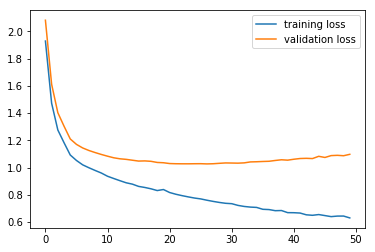

on epoch 0
	on iteration 14 / 15
	training loss = 1.702667
	validation loss = 1.865921
on epoch 1
	on iteration 14 / 15
	training loss = 1.569584
	validation loss = 1.725635
on epoch 2
	on iteration 14 / 15
	training loss = 1.594948
	validation loss = 1.754186
on epoch 3
	on iteration 14 / 15
	training loss = 1.513970
	validation loss = 1.665890
on epoch 4
	on iteration 14 / 15
	training loss = 1.435095
	validation loss = 1.582675
on epoch 5
	on iteration 14 / 15
	training loss = 1.370302
	validation loss = 1.512260
on epoch 6
	on iteration 14 / 15
	training loss = 1.282757
	validation loss = 1.414188
on epoch 7
	on iteration 14 / 15
	training loss = 1.231578
	validation loss = 1.358985
on epoch 8
	on iteration 14 / 15
	training loss = 1.188718
	validation loss = 1.313914
on epoch 9
	on iteration 14 / 15
	training loss = 1.158261
	validation loss = 1.283659
on epoch 10
	on iteration 14 / 15
	training loss = 1.123090
	validation loss = 1.248646
on epoch 11
	on iteration 14 / 15
	trainin

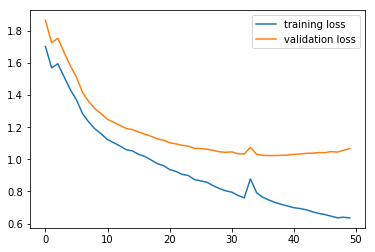

on epoch 0
	on iteration 14 / 15
	training loss = 2.290074
	validation loss = 2.463826
on epoch 1
	on iteration 14 / 15
	training loss = 2.288628
	validation loss = 2.464976
on epoch 2
	on iteration 14 / 15
	training loss = 2.271879
	validation loss = 2.445744
on epoch 3
	on iteration 14 / 15
	training loss = 2.260106
	validation loss = 2.428253
on epoch 4
	on iteration 14 / 15
	training loss = 2.256854
	validation loss = 2.424189
on epoch 5
	on iteration 14 / 15
	training loss = 2.257251
	validation loss = 2.420581
on epoch 6
	on iteration 14 / 15
	training loss = 2.250508
	validation loss = 2.413440
on epoch 7
	on iteration 14 / 15
	training loss = 2.776002
	validation loss = 3.042617
on epoch 8
	on iteration 14 / 15
	training loss = 2.268722
	validation loss = 2.442250
on epoch 9
	on iteration 14 / 15
	training loss = 2.261897
	validation loss = 2.432681
on epoch 10
	on iteration 14 / 15
	training loss = 2.258280
	validation loss = 2.427777
on epoch 11
	on iteration 14 / 15
	trainin

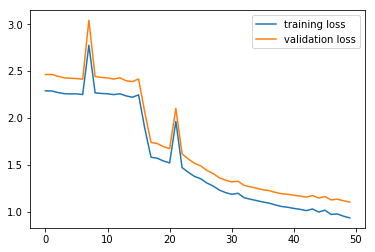

In [70]:
model = BeatlesLSTM(64, 1)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_1h = []
val_losses_1h = []
minibatch_size = 4

for epoch in range(50):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_1h += [train_loss]
    val_losses_1h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_1layer_mb4_epoch' + str(epoch))

ts = np.arange(50)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_1h), np.argmin(val_losses_1h)))
plt.plot(ts, train_losses_1h, label='training loss')
plt.plot(ts, val_losses_1h, label='validation loss')
plt.legend(loc='best')
plt.show()

#######################################

model = BeatlesLSTM(64, 2)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_2h = []
val_losses_2h = []
minibatch_size = 4

for epoch in range(50):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_2h += [train_loss]
    val_losses_2h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_2layer_mb4_epoch' + str(epoch))

ts = np.arange(50)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_2h), np.argmin(val_losses_2h)))
plt.plot(ts, train_losses_2h, label='training loss')
plt.plot(ts, val_losses_2h, label='validation loss')
plt.legend(loc='best')
plt.show()

########################################

model = BeatlesLSTM(64, 3)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_3h = []
val_losses_3h = []
minibatch_size = 4

for epoch in range(50):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_3h += [train_loss]
    val_losses_3h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_3layer_mb4_epoch' + str(epoch))

ts = np.arange(50)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_3h), np.argmin(val_losses_3h)))
plt.plot(ts, train_losses_3h, label='training loss')
plt.plot(ts, val_losses_3h, label='validation loss')
plt.legend(loc='best')
plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 1.798961
	validation loss = 1.943568
on epoch 1
	on iteration 14 / 15
	training loss = 1.396249
	validation loss = 1.519350
on epoch 2
	on iteration 14 / 15
	training loss = 1.209583
	validation loss = 1.323191
on epoch 3
	on iteration 14 / 15
	training loss = 1.153839
	validation loss = 1.267121
on epoch 4
	on iteration 14 / 15
	training loss = 1.100314
	validation loss = 1.219203
on epoch 5
	on iteration 14 / 15
	training loss = 1.069902
	validation loss = 1.191265
on epoch 6
	on iteration 14 / 15
	training loss = 1.041668
	validation loss = 1.169026
on epoch 7
	on iteration 14 / 15
	training loss = 1.006511
	validation loss = 1.143523
on epoch 8
	on iteration 14 / 15
	training loss = 0.985290
	validation loss = 1.130526
on epoch 9
	on iteration 14 / 15
	training loss = 0.962242
	validation loss = 1.116790
on epoch 10
	on iteration 14 / 15
	training loss = 0.943275
	validation loss = 1.105121
on epoch 11
	on iteration 14 / 15
	trainin

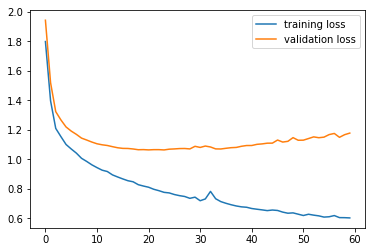

In [75]:
model = BeatlesLSTM(64, 1)
model.lstm.dropout = 0.2
train_losses_1h_dropout, val_losses_1h_dropout = train_loop(
        model, 60, train_data_ix, train_data_array, val_data_ix, val_data_array,
        checkpoint_name='model_checkpoint_beatles_h64s_1layer_dropout_mb4_epoch', minibatch_size=4)
ts = np.arange(len(train_losses_1h_dropout))
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_1h_dropout), np.argmin(val_losses_1h_dropout)))
plt.plot(ts, train_losses_1h_dropout, label='training loss')
plt.plot(ts, val_losses_1h_dropout, label='validation loss')
plt.legend(loc='best')
plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 2.266166
	validation loss = 2.425441
on epoch 1
	on iteration 14 / 15
	training loss = 2.277061
	validation loss = 2.436712
on epoch 2
	on iteration 14 / 15
	training loss = 2.266146
	validation loss = 2.423694
on epoch 3
	on iteration 14 / 15
	training loss = 2.258990
	validation loss = 2.409400
on epoch 4
	on iteration 14 / 15
	training loss = 2.257331
	validation loss = 2.412638
on epoch 5
	on iteration 14 / 15
	training loss = 2.226202
	validation loss = 2.375411
on epoch 6
	on iteration 14 / 15
	training loss = 2.205448
	validation loss = 2.363870
on epoch 7
	on iteration 14 / 15
	training loss = 2.227248
	validation loss = 2.404996
on epoch 8
	on iteration 14 / 15
	training loss = 1.916375
	validation loss = 2.076668
on epoch 9
	on iteration 14 / 15
	training loss = 1.588093
	validation loss = 1.731096
on epoch 10
	on iteration 14 / 15
	training loss = 1.560318
	validation loss = 1.701636
on epoch 11
	on iteration 14 / 15
	trainin

	on iteration 14 / 15
	training loss = 0.782830
	validation loss = 1.049759
on epoch 94
	on iteration 14 / 15
	training loss = 0.771078
	validation loss = 1.047650
on epoch 95
	on iteration 14 / 15
	training loss = 0.769839
	validation loss = 1.042769
on epoch 96
	on iteration 14 / 15
	training loss = 0.766514
	validation loss = 1.047575
on epoch 97
	on iteration 14 / 15
	training loss = 0.755576
	validation loss = 1.039063
on epoch 98
	on iteration 14 / 15
	training loss = 0.754362
	validation loss = 1.043228
on epoch 99
	on iteration 14 / 15
	training loss = 0.755404
	validation loss = 1.045299
min val_loss is 1.039063, after timestep 97


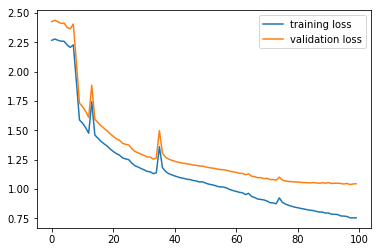

In [76]:
model = BeatlesLSTM(64, 2)
model.lstm.dropout = 0.2
train_losses_2h_dropout, val_losses_2h_dropout = train_loop(
        model, 100, train_data_ix, train_data_array, val_data_ix, val_data_array,
        checkpoint_name='model_checkpoint_beatles_h64s_2layer_dropout_mb4_epoch', minibatch_size=4)
ts = np.arange(len(train_losses_2h_dropout))
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_2h_dropout), np.argmin(val_losses_2h_dropout)))
plt.plot(ts, train_losses_2h_dropout, label='training loss')
plt.plot(ts, val_losses_2h_dropout, label='validation loss')
plt.legend(loc='best')
plt.show()

In [77]:
model = BeatlesLSTM(64, 3)
model.lstm.dropout = 0.2
train_losses_3h_dropout, val_losses_3h_dropout = train_loop(
        model, 150, train_data_ix, train_data_array, val_data_ix, val_data_array,
        checkpoint_name='model_checkpoint_beatles_h64s_3layer_dropout_mb4_epoch', minibatch_size=4)
ts = np.arange(len(train_losses_3h_dropout))
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_3h_dropout), np.argmin(val_losses_3h_dropout)))
plt.plot(ts, train_losses_3h_dropout, label='training loss')
plt.plot(ts, val_losses_3h_dropout, label='validation loss')
plt.legend(loc='best')
plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 2.276488
	validation loss = 2.433899
on epoch 1
	on iteration 14 / 15
	training loss = 2.312304
	validation loss = 2.429916
on epoch 2
	on iteration 14 / 15
	training loss = 2.273745
	validation loss = 2.431726
on epoch 3
	on iteration 14 / 15
	training loss = 2.268262
	validation loss = 2.423673
on epoch 4
	on iteration 14 / 15
	training loss = 2.609523
	validation loss = 2.686600
on epoch 5
	on iteration 14 / 15
	training loss = 2.261263
	validation loss = 2.412462
on epoch 6
	on iteration 14 / 15
	training loss = 2.261491
	validation loss = 2.413632
on epoch 7
	on iteration 14 / 15
	training loss = 2.264686
	validation loss = 2.418163
on epoch 8
	on iteration 14 / 15
	training loss = 2.265237
	validation loss = 2.419875
on epoch 9
	on iteration 14 / 15
	training loss = 2.257010
	validation loss = 2.410228
on epoch 10
	on iteration 14 / 15
	training loss = 2.211214
	validation loss = 2.353150
on epoch 11
	on iteration 14 / 15
	trainin

KeyboardInterrupt: 

on epoch 0
	on iteration 14 / 15
	training loss = 1.774267
	validation loss = 1.929182
on epoch 1
	on iteration 14 / 15
	training loss = 1.406093
	validation loss = 1.533759
on epoch 2
	on iteration 14 / 15
	training loss = 1.228338
	validation loss = 1.342304
on epoch 3
	on iteration 14 / 15
	training loss = 1.163087
	validation loss = 1.275812
on epoch 4
	on iteration 14 / 15
	training loss = 1.119608
	validation loss = 1.233675
on epoch 5
	on iteration 14 / 15
	training loss = 1.086010
	validation loss = 1.203592
on epoch 6
	on iteration 14 / 15
	training loss = 1.054959
	validation loss = 1.177406
on epoch 7
	on iteration 14 / 15
	training loss = 1.028332
	validation loss = 1.155201
on epoch 8
	on iteration 14 / 15
	training loss = 1.008072
	validation loss = 1.141644
on epoch 9
	on iteration 14 / 15
	training loss = 1.000245
	validation loss = 1.138077
on epoch 10
	on iteration 14 / 15
	training loss = 0.970864
	validation loss = 1.116408
on epoch 11
	on iteration 14 / 15
	trainin

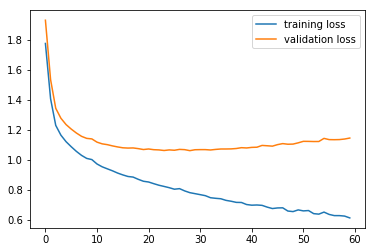

In [74]:
model = BeatlesLSTM(64, 1)
train_losses_1h, val_losses_1h = train_loop(
        model, 60, train_data_ix, train_data_array, val_data_ix, val_data_array,
        checkpoint_name='model_checkpoint_2_beatles_h64s_1layer_mb4_epoch', minibatch_size=4)
ts = np.arange(len(train_losses_1h))
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_1h), np.argmin(val_losses_1h)))
plt.plot(ts, train_losses_1h, label='training loss')
plt.plot(ts, val_losses_1h, label='validation loss')
plt.legend(loc='best')
plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 2.276262
	validation loss = 2.434748
on epoch 1
	on iteration 14 / 15
	training loss = 2.327072
	validation loss = 2.506306
on epoch 2
	on iteration 14 / 15
	training loss = 2.292463
	validation loss = 2.410080
on epoch 3
	on iteration 14 / 15
	training loss = 2.755445
	validation loss = 2.846961
on epoch 4
	on iteration 14 / 15
	training loss = 1.542633
	validation loss = 1.681218
on epoch 5
	on iteration 14 / 15
	training loss = 1.434209
	validation loss = 1.565294
on epoch 6
	on iteration 14 / 15
	training loss = 1.328175
	validation loss = 1.455222
on epoch 7
	on iteration 14 / 15
	training loss = 1.252651
	validation loss = 1.375383
on epoch 8
	on iteration 14 / 15
	training loss = 1.196936
	validation loss = 1.318019
on epoch 9
	on iteration 14 / 15
	training loss = 1.165550
	validation loss = 1.283998
on epoch 10
	on iteration 14 / 15
	training loss = 1.124590
	validation loss = 1.247057
on epoch 11
	on iteration 14 / 15
	trainin

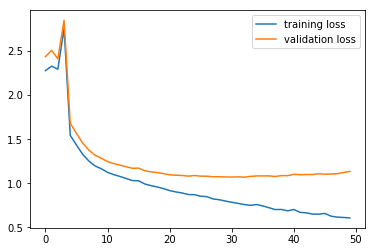

In [16]:
model = BeatlesLSTM(64, 2)
train_losses_2h, val_losses_2h = train_loop(
        model, 50, train_data_ix, train_data_array, val_data_ix, val_data_array,
        checkpoint_name='model_checkpoint_2_beatles_h64s_2layer_mb4_epoch', minibatch_size=4)
ts = np.arange(len(train_losses_2h))
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_2h), np.argmin(val_losses_2h)))
plt.plot(ts, train_losses_2h, label='training loss')
plt.plot(ts, val_losses_2h, label='validation loss')
plt.legend(loc='best')
plt.show()

# Transfer Learning from Gutenberg with Dropout

training all but layer 0
on epoch 0
	on iteration 14 / 15
	training loss = 1.064467
	validation loss = 1.194925
on epoch 1
	on iteration 14 / 15
	training loss = 1.004070
	validation loss = 1.131798
on epoch 2
	on iteration 14 / 15
	training loss = 0.974578
	validation loss = 1.105846
on epoch 3
	on iteration 14 / 15
	training loss = 0.950237
	validation loss = 1.084719
on epoch 4
	on iteration 14 / 15
	training loss = 0.932754
	validation loss = 1.070252
on epoch 5
	on iteration 14 / 15
	training loss = 0.917996
	validation loss = 1.060109
on epoch 6
	on iteration 14 / 15
	training loss = 0.904753
	validation loss = 1.049461
on epoch 7
	on iteration 14 / 15
	training loss = 0.895364
	validation loss = 1.042015
on epoch 8
	on iteration 14 / 15
	training loss = 0.885759
	validation loss = 1.034265
on epoch 9
	on iteration 14 / 15
	training loss = 0.877940
	validation loss = 1.028841
on epoch 10
	on iteration 14 / 15
	training loss = 0.871695
	validation loss = 1.025578
on epoch 11
	on i

	on iteration 14 / 15
	training loss = 0.628914
	validation loss = 0.970081
on epoch 94
	on iteration 14 / 15
	training loss = 0.628200
	validation loss = 0.969320
on epoch 95
	on iteration 14 / 15
	training loss = 0.626389
	validation loss = 0.967687
on epoch 96
	on iteration 14 / 15
	training loss = 0.624861
	validation loss = 0.969415
on epoch 97
	on iteration 14 / 15
	training loss = 0.623998
	validation loss = 0.970861
on epoch 98
	on iteration 14 / 15
	training loss = 0.623265
	validation loss = 0.969693
on epoch 99
	on iteration 14 / 15
	training loss = 0.620556
	validation loss = 0.968680
min val_loss is 0.961813, after epoch 58


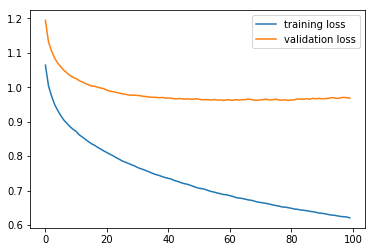

training all but layer 1
on epoch 0
	on iteration 14 / 15
	training loss = 1.068009
	validation loss = 1.200250
on epoch 1
	on iteration 14 / 15
	training loss = 1.007258
	validation loss = 1.139592
on epoch 2
	on iteration 14 / 15
	training loss = 0.974624
	validation loss = 1.107194
on epoch 3
	on iteration 14 / 15
	training loss = 0.952170
	validation loss = 1.087591
on epoch 4
	on iteration 14 / 15
	training loss = 0.935558
	validation loss = 1.071210
on epoch 5
	on iteration 14 / 15
	training loss = 0.921046
	validation loss = 1.059229
on epoch 6
	on iteration 14 / 15
	training loss = 0.909742
	validation loss = 1.050825
on epoch 7
	on iteration 14 / 15
	training loss = 0.899024
	validation loss = 1.042454
on epoch 8
	on iteration 14 / 15
	training loss = 0.889056
	validation loss = 1.036476
on epoch 9
	on iteration 14 / 15
	training loss = 0.880658
	validation loss = 1.030636
on epoch 10
	on iteration 14 / 15
	training loss = 0.874128
	validation loss = 1.029396
on epoch 11
	on i

	on iteration 14 / 15
	training loss = 0.642375
	validation loss = 0.962285
on epoch 94
	on iteration 14 / 15
	training loss = 0.641215
	validation loss = 0.964157
on epoch 95
	on iteration 14 / 15
	training loss = 0.638190
	validation loss = 0.963333
on epoch 96
	on iteration 14 / 15
	training loss = 0.635836
	validation loss = 0.964257
on epoch 97
	on iteration 14 / 15
	training loss = 0.635460
	validation loss = 0.965731
on epoch 98
	on iteration 14 / 15
	training loss = 0.635688
	validation loss = 0.966055
on epoch 99
	on iteration 14 / 15
	training loss = 0.637256
	validation loss = 0.966489
min val_loss is 0.954291, after epoch 69


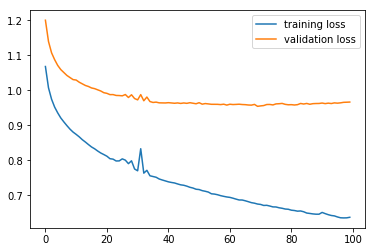

training all but layer 2
on epoch 0
	on iteration 14 / 15
	training loss = 1.080474
	validation loss = 1.207556
on epoch 1
	on iteration 14 / 15
	training loss = 1.018102
	validation loss = 1.148441
on epoch 2
	on iteration 14 / 15
	training loss = 0.981216
	validation loss = 1.115067
on epoch 3
	on iteration 14 / 15
	training loss = 0.962052
	validation loss = 1.101031
on epoch 4
	on iteration 14 / 15
	training loss = 0.941038
	validation loss = 1.084064
on epoch 5
	on iteration 14 / 15
	training loss = 0.925120
	validation loss = 1.070687
on epoch 6
	on iteration 14 / 15
	training loss = 0.913550
	validation loss = 1.062726
on epoch 7
	on iteration 14 / 15
	training loss = 0.901299
	validation loss = 1.053975
on epoch 8
	on iteration 14 / 15
	training loss = 0.891813
	validation loss = 1.046578
on epoch 9
	on iteration 14 / 15
	training loss = 0.882203
	validation loss = 1.038362
on epoch 10
	on iteration 14 / 15
	training loss = 0.874973
	validation loss = 1.032365
on epoch 11
	on i

	on iteration 14 / 15
	training loss = 0.650320
	validation loss = 0.971491
on epoch 94
	on iteration 14 / 15
	training loss = 0.647661
	validation loss = 0.972550
on epoch 95
	on iteration 14 / 15
	training loss = 0.646874
	validation loss = 0.971865
on epoch 96
	on iteration 14 / 15
	training loss = 0.645980
	validation loss = 0.976351
on epoch 97
	on iteration 14 / 15
	training loss = 0.645616
	validation loss = 0.973085
on epoch 98
	on iteration 14 / 15
	training loss = 0.643563
	validation loss = 0.974140
on epoch 99
	on iteration 14 / 15
	training loss = 0.643562
	validation loss = 0.976459
min val_loss is 0.964402, after epoch 42


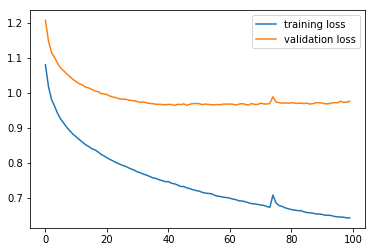

In [80]:
epochs = 100
layers = [0, 1, 2]
gt_losses = np.zeros((len(layers), epochs))
gv_losses = np.zeros((len(layers), epochs))
gutenberg_models = []
for l in layers:
    print('training all but layer %d' % l)
    gutenberg_model = BeatlesLSTM(64, 3)
    gutenberg_model.load_state_dict(torch.load('model_checkpoint_3_h64_3layer_epoch46'))
    gutenberg_model.lstm.dropout = 0.2
    
    gt_losses[l], gv_losses[l] = train_loop(gutenberg_model, epochs, train_data_ix, train_data_array, val_data_ix,
                                            val_data_array,
                                            checkpoint_name='transferred_dropout_allbutlayer' + str(l) + '_epoch',
                                            optimizer=optim.RMSprop(all_but_layer_params(gutenberg_model, l)))
    gutenberg_models += [gutenberg_model]
    
    ts = np.arange(epochs)
    print('min val_loss is %f, after epoch %d' % (np.min(gv_losses[l]), np.argmin(gv_losses[l])))
    plt.plot(ts, gt_losses[l], label='training loss')
    plt.plot(ts, gv_losses[l], label='validation loss')
    plt.legend(loc='best')
    plt.show()

training layer 0
on epoch 0
	on iteration 14 / 15
	training loss = 1.464175
	validation loss = 1.576776
on epoch 1
	on iteration 14 / 15
	training loss = 1.094162
	validation loss = 1.228373
on epoch 2
	on iteration 14 / 15
	training loss = 1.042047
	validation loss = 1.179316
on epoch 3
	on iteration 14 / 15
	training loss = 1.007468
	validation loss = 1.144640
on epoch 4
	on iteration 14 / 15
	training loss = 0.987541
	validation loss = 1.124531
on epoch 5
	on iteration 14 / 15
	training loss = 0.974122
	validation loss = 1.114074
on epoch 6
	on iteration 14 / 15
	training loss = 0.962193
	validation loss = 1.102222
on epoch 7
	on iteration 14 / 15
	training loss = 0.954698
	validation loss = 1.094249
on epoch 8
	on iteration 14 / 15
	training loss = 0.947954
	validation loss = 1.089638
on epoch 9
	on iteration 14 / 15
	training loss = 0.940872
	validation loss = 1.083992
on epoch 10
	on iteration 14 / 15
	training loss = 0.935238
	validation loss = 1.078543
on epoch 11
	on iteration

	on iteration 14 / 15
	training loss = 0.791473
	validation loss = 1.004258
on epoch 94
	on iteration 14 / 15
	training loss = 0.789320
	validation loss = 1.003745
on epoch 95
	on iteration 14 / 15
	training loss = 0.789191
	validation loss = 1.004554
on epoch 96
	on iteration 14 / 15
	training loss = 0.787767
	validation loss = 1.003112
on epoch 97
	on iteration 14 / 15
	training loss = 0.787120
	validation loss = 1.004004
on epoch 98
	on iteration 14 / 15
	training loss = 0.786417
	validation loss = 1.002915
on epoch 99
	on iteration 14 / 15
	training loss = 0.785651
	validation loss = 1.001140
min val_loss is 1.001140, after epoch 99


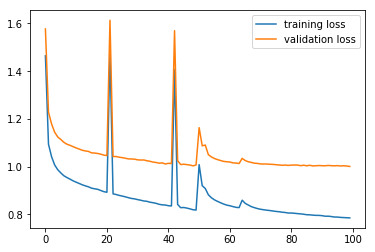

training layer 1
on epoch 0
	on iteration 14 / 15
	training loss = 1.114695
	validation loss = 1.262529
on epoch 1
	on iteration 14 / 15
	training loss = 1.050406
	validation loss = 1.192332
on epoch 2
	on iteration 14 / 15
	training loss = 1.016918
	validation loss = 1.155029
on epoch 3
	on iteration 14 / 15
	training loss = 0.991940
	validation loss = 1.130360
on epoch 4
	on iteration 14 / 15
	training loss = 0.976380
	validation loss = 1.112923
on epoch 5
	on iteration 14 / 15
	training loss = 0.962497
	validation loss = 1.098503
on epoch 6
	on iteration 14 / 15
	training loss = 0.954618
	validation loss = 1.091741
on epoch 7
	on iteration 14 / 15
	training loss = 0.945961
	validation loss = 1.082482
on epoch 8
	on iteration 14 / 15
	training loss = 0.939618
	validation loss = 1.076204
on epoch 9
	on iteration 14 / 15
	training loss = 0.933683
	validation loss = 1.070316
on epoch 10
	on iteration 14 / 15
	training loss = 0.926500
	validation loss = 1.064226
on epoch 11
	on iteration

	on iteration 14 / 15
	training loss = 0.758549
	validation loss = 0.985635
on epoch 94
	on iteration 14 / 15
	training loss = 0.758244
	validation loss = 0.984865
on epoch 95
	on iteration 14 / 15
	training loss = 0.755869
	validation loss = 0.984901
on epoch 96
	on iteration 14 / 15
	training loss = 0.755455
	validation loss = 0.985447
on epoch 97
	on iteration 14 / 15
	training loss = 0.755379
	validation loss = 0.983542
on epoch 98
	on iteration 14 / 15
	training loss = 0.753670
	validation loss = 0.982678
on epoch 99
	on iteration 14 / 15
	training loss = 0.752781
	validation loss = 0.982971
min val_loss is 0.982678, after epoch 98


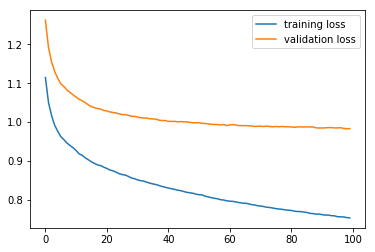

training layer 2
on epoch 0
	on iteration 14 / 15
	training loss = 1.059068
	validation loss = 1.190254
on epoch 1
	on iteration 14 / 15
	training loss = 1.023727
	validation loss = 1.149689
on epoch 2
	on iteration 14 / 15
	training loss = 0.997122
	validation loss = 1.121001
on epoch 3
	on iteration 14 / 15
	training loss = 0.977572
	validation loss = 1.100971
on epoch 4
	on iteration 14 / 15
	training loss = 0.959178
	validation loss = 1.083087
on epoch 5
	on iteration 14 / 15
	training loss = 0.946877
	validation loss = 1.071649
on epoch 6
	on iteration 14 / 15
	training loss = 0.938386
	validation loss = 1.063781
on epoch 7
	on iteration 14 / 15
	training loss = 0.929739
	validation loss = 1.056330
on epoch 8
	on iteration 14 / 15
	training loss = 0.923017
	validation loss = 1.050502
on epoch 9
	on iteration 14 / 15
	training loss = 0.917586
	validation loss = 1.046410
on epoch 10
	on iteration 14 / 15
	training loss = 0.912213
	validation loss = 1.042262
on epoch 11
	on iteration

	on iteration 14 / 15
	training loss = 0.746368
	validation loss = 0.983031
on epoch 94
	on iteration 14 / 15
	training loss = 0.746209
	validation loss = 0.984167
on epoch 95
	on iteration 14 / 15
	training loss = 0.744546
	validation loss = 0.983893
on epoch 96
	on iteration 14 / 15
	training loss = 0.743669
	validation loss = 0.983183
on epoch 97
	on iteration 14 / 15
	training loss = 0.746992
	validation loss = 0.990210
on epoch 98
	on iteration 14 / 15
	training loss = 0.742373
	validation loss = 0.983424
on epoch 99
	on iteration 14 / 15
	training loss = 0.741281
	validation loss = 0.982682
min val_loss is 0.978707, after epoch 81


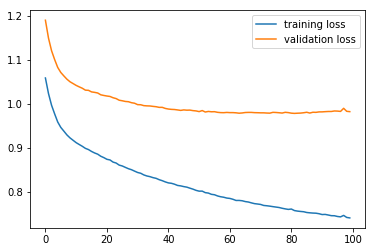

In [81]:
epochs = 100
layers = [0, 1, 2]
gt_losses = np.zeros((len(layers), epochs))
gv_losses = np.zeros((len(layers), epochs))
gutenberg_models = []
for l in layers:
    print('training layer %d' % l)
    gutenberg_model = BeatlesLSTM(64, 3)
    gutenberg_model.load_state_dict(torch.load('model_checkpoint_3_h64_3layer_epoch46'))
    gutenberg_model.lstm.dropout = 0.2
    
    gt_losses[l], gv_losses[l] = train_loop(gutenberg_model, epochs, train_data_ix, train_data_array, val_data_ix,
                                            val_data_array,
                                            checkpoint_name='transferred_dropout_layer' + str(l) + '_epoch',
                                            optimizer=optim.RMSprop(layer_params_and_last(gutenberg_model, l)))
    gutenberg_models += [gutenberg_model]
    
    ts = np.arange(epochs)
    print('min val_loss is %f, after epoch %d' % (np.min(gv_losses[l]), np.argmin(gv_losses[l])))
    plt.plot(ts, gt_losses[l], label='training loss')
    plt.plot(ts, gv_losses[l], label='validation loss')
    plt.legend(loc='best')
    plt.show()

# Transer Learning From Gutenberg with no Dropout

training all but layer 0
on epoch 0
	on iteration 14 / 15
	training loss = 0.974751
	validation loss = 1.130862
on epoch 1
	on iteration 14 / 15
	training loss = 0.883112
	validation loss = 1.066264
on epoch 2
	on iteration 14 / 15
	training loss = 0.830862
	validation loss = 1.035049
on epoch 3
	on iteration 14 / 15
	training loss = 0.792948
	validation loss = 1.017642
on epoch 4
	on iteration 14 / 15
	training loss = 0.766140
	validation loss = 1.009535
on epoch 5
	on iteration 14 / 15
	training loss = 0.744867
	validation loss = 1.004593
on epoch 6
	on iteration 14 / 15
	training loss = 0.725395
	validation loss = 1.002655
on epoch 7
	on iteration 14 / 15
	training loss = 0.709625
	validation loss = 1.000713
on epoch 8
	on iteration 14 / 15
	training loss = 0.693565
	validation loss = 1.000926
on epoch 9
	on iteration 14 / 15
	training loss = 0.679574
	validation loss = 1.002946
on epoch 10
	on iteration 14 / 15
	training loss = 0.665216
	validation loss = 1.002548
on epoch 11
	on i

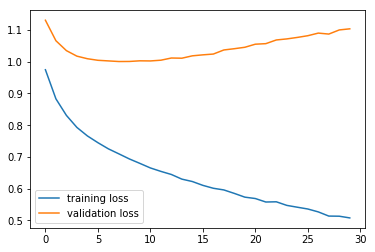

training all but layer 1
on epoch 0
	on iteration 14 / 15
	training loss = 1.012419
	validation loss = 1.166129
on epoch 1
	on iteration 14 / 15
	training loss = 0.905364
	validation loss = 1.089643
on epoch 2
	on iteration 14 / 15
	training loss = 0.851647
	validation loss = 1.058074
on epoch 3
	on iteration 14 / 15
	training loss = 0.817740
	validation loss = 1.041367
on epoch 4
	on iteration 14 / 15
	training loss = 0.790405
	validation loss = 1.030113
on epoch 5
	on iteration 14 / 15
	training loss = 0.769538
	validation loss = 1.025196
on epoch 6
	on iteration 14 / 15
	training loss = 0.750613
	validation loss = 1.019952
on epoch 7
	on iteration 14 / 15
	training loss = 0.734571
	validation loss = 1.018790
on epoch 8
	on iteration 14 / 15
	training loss = 0.721320
	validation loss = 1.015439
on epoch 9
	on iteration 14 / 15
	training loss = 0.706783
	validation loss = 1.015108
on epoch 10
	on iteration 14 / 15
	training loss = 0.695964
	validation loss = 1.016605
on epoch 11
	on i

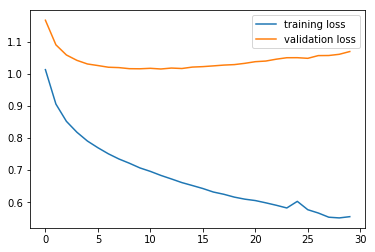

training all but layer 2
on epoch 0
	on iteration 14 / 15
	training loss = 6.068838
	validation loss = 6.013880
on epoch 1
	on iteration 14 / 15
	training loss = 1.709312
	validation loss = 1.872518
on epoch 2
	on iteration 14 / 15
	training loss = 1.557410
	validation loss = 1.713736
on epoch 3
	on iteration 14 / 15
	training loss = 1.482025
	validation loss = 1.635949
on epoch 4
	on iteration 14 / 15
	training loss = 1.440757
	validation loss = 1.592579
on epoch 5
	on iteration 14 / 15
	training loss = 1.395484
	validation loss = 1.547460
on epoch 6
	on iteration 14 / 15
	training loss = 1.365972
	validation loss = 1.518540
on epoch 7
	on iteration 14 / 15
	training loss = 1.343288
	validation loss = 1.497677
on epoch 8
	on iteration 14 / 15
	training loss = 1.315147
	validation loss = 1.470298
on epoch 9
	on iteration 14 / 15
	training loss = 1.290782
	validation loss = 1.448685
on epoch 10
	on iteration 14 / 15
	training loss = 1.275443
	validation loss = 1.432208
on epoch 11
	on i

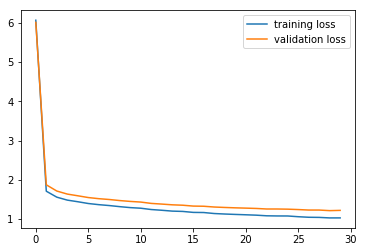

In [82]:
epochs = 30
layers = [0, 1, 2]
gt_losses = np.zeros((len(layers), epochs))
gv_losses = np.zeros((len(layers), epochs))
for l, enabled_layer in enumerate(layers):
    print('training all but layer %d' % l)
    gutenberg_model = BeatlesLSTM(64, 3)
    gutenberg_model.load_state_dict(torch.load('model_checkpoint_3_h64_3layer_epoch46'))
    gutenberg_model.lstm.dropout = 0.0
    
    gt_losses[l], gv_losses[l] = train_loop(gutenberg_model, epochs, train_data_ix, train_data_array, val_data_ix,
                                            val_data_array,
                                            checkpoint_name='transferred_allbutlayer' + str(l) + '_epoch',
                                            optimizer=optim.RMSprop(all_but_layer_params(gutenberg_model, l)))
    
    ts = np.arange(epochs)
    print('min val_loss is %f, after epoch %d' % (np.min(gv_losses[l]), np.argmin(gv_losses[l])))
    plt.plot(ts, gt_losses[l], label='training loss')
    plt.plot(ts, gv_losses[l], label='validation loss')
    plt.legend(loc='best')
    plt.show()

training layer 0
on epoch 0
	on iteration 14 / 15
	training loss = 12.059266
	validation loss = 11.247555
on epoch 1
	on iteration 14 / 15
	training loss = 12.662909
	validation loss = 11.770547
on epoch 2
	on iteration 14 / 15
	training loss = 5.759174
	validation loss = 5.513362
on epoch 3
	on iteration 14 / 15
	training loss = 1.278643
	validation loss = 1.449518
on epoch 4
	on iteration 14 / 15
	training loss = 1.108313
	validation loss = 1.295789
on epoch 5
	on iteration 14 / 15
	training loss = 1.046410
	validation loss = 1.227565
on epoch 6
	on iteration 14 / 15
	training loss = 1.002530
	validation loss = 1.194210
on epoch 7
	on iteration 14 / 15
	training loss = 0.972471
	validation loss = 1.177919
on epoch 8
	on iteration 14 / 15
	training loss = 0.948707
	validation loss = 1.158705
on epoch 9
	on iteration 14 / 15
	training loss = 0.928981
	validation loss = 1.144033
on epoch 10
	on iteration 14 / 15
	training loss = 0.912314
	validation loss = 1.132764
on epoch 11
	on itera

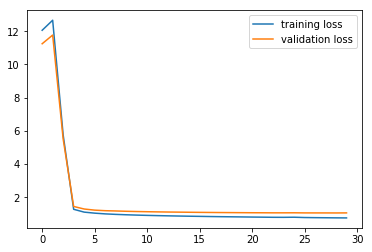

training layer 1
on epoch 0
	on iteration 14 / 15
	training loss = 1.070656
	validation loss = 1.234335
on epoch 1
	on iteration 14 / 15
	training loss = 0.963471
	validation loss = 1.144649
on epoch 2
	on iteration 14 / 15
	training loss = 0.911394
	validation loss = 1.107449
on epoch 3
	on iteration 14 / 15
	training loss = 0.878194
	validation loss = 1.085097
on epoch 4
	on iteration 14 / 15
	training loss = 0.852671
	validation loss = 1.069937
on epoch 5
	on iteration 14 / 15
	training loss = 0.832599
	validation loss = 1.058891
on epoch 6
	on iteration 14 / 15
	training loss = 0.813999
	validation loss = 1.048433
on epoch 7
	on iteration 14 / 15
	training loss = 0.798991
	validation loss = 1.041397
on epoch 8
	on iteration 14 / 15
	training loss = 0.784508
	validation loss = 1.033400
on epoch 9
	on iteration 14 / 15
	training loss = 0.771069
	validation loss = 1.028368
on epoch 10
	on iteration 14 / 15
	training loss = 0.759211
	validation loss = 1.022128
on epoch 11
	on iteration

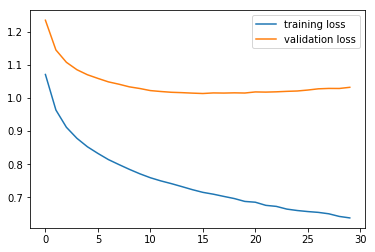

training layer 2
on epoch 0
	on iteration 14 / 15
	training loss = 0.949204
	validation loss = 1.102766
on epoch 1
	on iteration 14 / 15
	training loss = 0.880973
	validation loss = 1.053504
on epoch 2
	on iteration 14 / 15
	training loss = 0.841718
	validation loss = 1.028814
on epoch 3
	on iteration 14 / 15
	training loss = 0.813809
	validation loss = 1.014531
on epoch 4
	on iteration 14 / 15
	training loss = 0.792771
	validation loss = 1.005736
on epoch 5
	on iteration 14 / 15
	training loss = 0.775400
	validation loss = 0.999815
on epoch 6
	on iteration 14 / 15
	training loss = 0.760308
	validation loss = 0.996080
on epoch 7
	on iteration 14 / 15
	training loss = 0.747147
	validation loss = 0.993818
on epoch 8
	on iteration 14 / 15
	training loss = 0.735085
	validation loss = 0.992137
on epoch 9
	on iteration 14 / 15
	training loss = 0.723994
	validation loss = 0.991288
on epoch 10
	on iteration 14 / 15
	training loss = 0.714242
	validation loss = 0.991502
on epoch 11
	on iteration

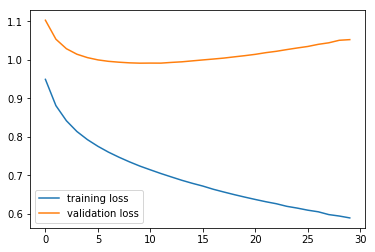

In [83]:
epochs = 30
layers = [0, 1, 2]
gt_losses = np.zeros((len(layers), epochs))
gv_losses = np.zeros((len(layers), epochs))
for l, enabled_layer in enumerate(layers):
    print('training layer %d' % l)
    gutenberg_model = BeatlesLSTM(64, 3)
    gutenberg_model.load_state_dict(torch.load('model_checkpoint_3_h64_3layer_epoch46'))
    gutenberg_model.lstm.dropout = 0.0
    
    gt_losses[l], gv_losses[l] = train_loop(gutenberg_model, epochs, train_data_ix, train_data_array, val_data_ix,
                                            val_data_array,
                                            checkpoint_name='transferred_layer' + str(l) + '_epoch',
                                            optimizer=optim.RMSprop(layer_params_and_last(gutenberg_model, l)))
    
    ts = np.arange(epochs)
    print('min val_loss is %f, after epoch %d' % (np.min(gv_losses[l]), np.argmin(gv_losses[l])))
    plt.plot(ts, gt_losses[l], label='training loss')
    plt.plot(ts, gv_losses[l], label='validation loss')
    plt.legend(loc='best')
    plt.show()

# Transfer Learning from Lyrics with Dropout

In [ ]:
epochs = 30
layers = [0, 1, 2]
gt_losses = np.zeros((len(layers), epochs))
gv_losses = np.zeros((len(layers), epochs))
lyrics_models = []
for l in layers:
    print('training layer %d' % l)
    lyrics_model = BeatlesLSTM(64, 3)
    lyrics_model.load_state_dict(torch.load('lyrics_h64_l3_mb163'))
    lyrics_model.lstm.dropout = 0.2
    
    print('initial training loss is %f' % model_loss(lyrics_model, torch.nn.CrossEntropyLoss(), train_data_ix, train_data_array))
    print('initial validation loss is %f' % model_loss(lyrics_model, torch.nn.CrossEntropyLoss(), val_data_ix, val_data_array))
    
    gt_losses[l], gv_losses[l] = train_loop(lyrics_model, epochs, train_data_ix, train_data_array, val_data_ix,
                                            val_data_array,
                                            checkpoint_name='transferred_fromlyrics_dropout_layer' + str(l) + '_epoch',
                                            optimizer=optim.RMSprop(layer_params_and_last(lyrics_model, l), lr=0.001))
    lyrics_models += [lyrics_model]
    
    ts = np.arange(epochs)
    print('min val_loss is %f, after epoch %d' % (np.min(gv_losses[l]), np.argmin(gv_losses[l])))
    plt.plot(ts, gt_losses[l], label='training loss')
    plt.plot(ts, gv_losses[l], label='validation loss')
    plt.legend(loc='best')
    plt.show()

training layer 0
initial training loss is 0.878545
initial validation loss is 0.921845
on epoch 0
	on iteration 14 / 15
	training loss = 0.840463
	validation loss = 0.885587
on epoch 1
	on iteration 14 / 15
	training loss = 0.828187
	validation loss = 0.873491
on epoch 2
	on iteration 14 / 15
	training loss = 0.819655
	validation loss = 0.865846
on epoch 3
	on iteration 1 / 15

In [ ]:
epochs = 50
layers = [0, 1, 2]
gt_losses = np.zeros((len(layers), epochs))
gv_losses = np.zeros((len(layers), epochs))
lyrics_models = []
for l in layers:
    print('training all but layer %d' % l)
    lyrics_model = BeatlesLSTM(64, 3)
    lyrics_model.load_state_dict(torch.load('lyrics_h64_l3_mb163'))
    lyrics_model.lstm.dropout = 0.2
    
    print('initial training loss is %f' % model_loss(lyrics_model, torch.nn.CrossEntropyLoss(), train_data_ix, train_data_array))
    print('initial validation loss is %f' % model_loss(lyrics_model, torch.nn.CrossEntropyLoss(), val_data_ix, val_data_array))
    
    gt_losses[l], gv_losses[l] = train_loop(lyrics_model, epochs, train_data_ix, train_data_array, val_data_ix,
                                            val_data_array,
                                            checkpoint_name='transferred_fromlyrics_dropout_allbutlayer' + str(l) + '_epoch',
                                            optimizer=optim.RMSprop(all_but_layer_params(lyrics_model, l), lr=0.001))
    lyrics_models += [lyrics_model]
    
    ts = np.arange(epochs)
    print('min val_loss is %f, after epoch %d' % (np.min(gv_losses[l]), np.argmin(gv_losses[l])))
    plt.plot(ts, gt_losses[l], label='training loss')
    plt.plot(ts, gv_losses[l], label='validation loss')
    plt.legend(loc='best')
    plt.show()

In [56]:
gutenberg_model = BeatlesLSTM(64, 3)
gutenberg_model.load_state_dict(torch.load('transferred_dropout_allbutlayer1_epoch79'))
gutenberg_model.lstm.dropout = 0.2

gt_losses[l], gv_losses[l] = train_loop(gutenberg_model, epochs, train_data_ix, train_data_array, val_data_ix,
                                        val_data_array,
                                        checkpoint_name='transferred_final_epoch')

on epoch 0
	on iteration 14 / 15
	training loss = 0.747834
	validation loss = 0.975502
on epoch 1
	on iteration 14 / 15
	training loss = 0.720403
	validation loss = 0.969045
on epoch 2
	on iteration 4 / 15

KeyboardInterrupt: 

training all but layer 0
on epoch 0
	on iteration 14 / 15
	training loss = 1.019858
	validation loss = 1.182038
on epoch 1
	on iteration 14 / 15
	training loss = 0.910667
	validation loss = 1.093221
on epoch 2
	on iteration 14 / 15
	training loss = 0.858170
	validation loss = 1.060593
on epoch 3
	on iteration 14 / 15
	training loss = 0.821337
	validation loss = 1.040861
on epoch 4
	on iteration 14 / 15
	training loss = 0.791582
	validation loss = 1.028272
on epoch 5
	on iteration 14 / 15
	training loss = 0.767695
	validation loss = 1.020672
on epoch 6
	on iteration 14 / 15
	training loss = 0.746434
	validation loss = 1.016010
on epoch 7
	on iteration 14 / 15
	training loss = 0.727486
	validation loss = 1.013488
on epoch 8
	on iteration 14 / 15
	training loss = 0.710736
	validation loss = 1.011769
on epoch 9
	on iteration 14 / 15
	training loss = 0.697548
	validation loss = 1.012385
on epoch 10
	on iteration 14 / 15
	training loss = 0.682867
	validation loss = 1.013005
on epoch 11
	on i

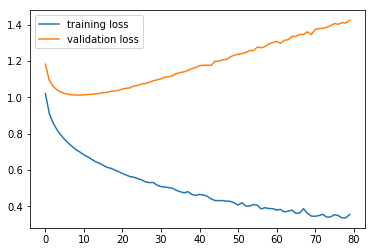

training all but layer 1
on epoch 0
	on iteration 14 / 15
	training loss = 1.054929
	validation loss = 1.215344
on epoch 1
	on iteration 14 / 15
	training loss = 0.935731
	validation loss = 1.115342
on epoch 2
	on iteration 14 / 15
	training loss = 0.878871
	validation loss = 1.080509
on epoch 3
	on iteration 14 / 15
	training loss = 0.840125
	validation loss = 1.062804
on epoch 4
	on iteration 14 / 15
	training loss = 0.811367
	validation loss = 1.049967
on epoch 5
	on iteration 14 / 15
	training loss = 0.788604
	validation loss = 1.042946
on epoch 6
	on iteration 14 / 15
	training loss = 0.769954
	validation loss = 1.035600
on epoch 7
	on iteration 14 / 15
	training loss = 0.751736
	validation loss = 1.031167
on epoch 8
	on iteration 14 / 15
	training loss = 0.735264
	validation loss = 1.027911
on epoch 9
	on iteration 14 / 15
	training loss = 0.720786
	validation loss = 1.026074
on epoch 10
	on iteration 14 / 15
	training loss = 0.708374
	validation loss = 1.025691
on epoch 11
	on i

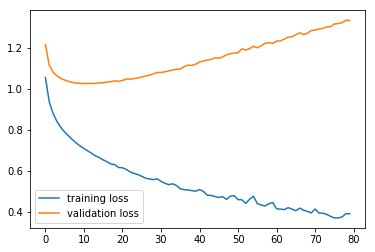

training all but layer 2
on epoch 0
	on iteration 14 / 15
	training loss = 4.480817
	validation loss = 4.360365
on epoch 1
	on iteration 14 / 15
	training loss = 1.120126
	validation loss = 1.285880
on epoch 2
	on iteration 14 / 15
	training loss = 1.003267
	validation loss = 1.188155
on epoch 3
	on iteration 14 / 15
	training loss = 0.948764
	validation loss = 1.148061
on epoch 4
	on iteration 14 / 15
	training loss = 0.911351
	validation loss = 1.124870
on epoch 5
	on iteration 14 / 15
	training loss = 0.882509
	validation loss = 1.108912
on epoch 6
	on iteration 14 / 15
	training loss = 0.860155
	validation loss = 1.094283
on epoch 7
	on iteration 14 / 15
	training loss = 0.839957
	validation loss = 1.086355
on epoch 8
	on iteration 14 / 15
	training loss = 0.823081
	validation loss = 1.077889
on epoch 9
	on iteration 14 / 15
	training loss = 0.808954
	validation loss = 1.072778
on epoch 10
	on iteration 14 / 15
	training loss = 0.795403
	validation loss = 1.066922
on epoch 11
	on i

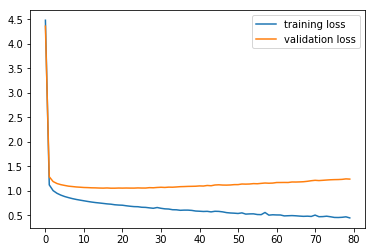

In [36]:
epochs = 80
layers = [0, 1, 2]
gt_losses_nodropout = np.zeros((len(layers), epochs))
gv_losses_nodropout = np.zeros((len(layers), epochs))
for l, enabled_layer in enumerate(layers):
    print('training all but layer %d' % l)
    gutenberg_model = BeatlesLSTM(64, 3)
    gutenberg_model.load_state_dict(torch.load('model_checkpoint_3_h64_3layer_epoch40'))
    # no dropout here
    freeze_layer(gutenberg_model, l)

    gt_losses_nodropout[l], gv_losses_nodropout[l] = train_loop(gutenberg_model, epochs, train_data_ix, train_data_array,
                                                                val_data_ix, val_data_array,
                                                    optimizer=optim.RMSprop(all_but_layer_params(gutenberg_model, l)))
    
    ts = np.arange(epochs)
    print('min val_loss is %f, after epoch %d' % (np.min(gv_losses_nodropout[l]), np.argmin(gv_losses_nodropout[l])))
    plt.plot(ts, gt_losses_nodropout[l], label='training loss')
    plt.plot(ts, gv_losses_nodropout[l], label='validation loss')
    plt.legend(loc='best')
    plt.show()

training all but layer 0
on epoch 0
	on iteration 14 / 15
	training loss = 8.853760
	validation loss = 8.364557
on epoch 1
	on iteration 14 / 15
	training loss = 1.263583
	validation loss = 1.442375
on epoch 2
	on iteration 14 / 15
	training loss = 1.083433
	validation loss = 1.260095
on epoch 3
	on iteration 14 / 15
	training loss = 1.016955
	validation loss = 1.201525
on epoch 4
	on iteration 14 / 15
	training loss = 0.976767
	validation loss = 1.168541
on epoch 5
	on iteration 14 / 15
	training loss = 0.947989
	validation loss = 1.146083
on epoch 6
	on iteration 14 / 15
	training loss = 0.925091
	validation loss = 1.128619
on epoch 7
	on iteration 14 / 15
	training loss = 0.905517
	validation loss = 1.114085
on epoch 8
	on iteration 14 / 15
	training loss = 0.888412
	validation loss = 1.103314
on epoch 9
	on iteration 14 / 15
	training loss = 0.873612
	validation loss = 1.094239
on epoch 10
	on iteration 14 / 15
	training loss = 0.860483
	validation loss = 1.085783
on epoch 11
	on i

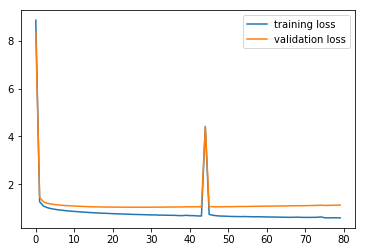

training all but layer 1
on epoch 0
	on iteration 14 / 15
	training loss = 1.082535
	validation loss = 1.253878
on epoch 1
	on iteration 14 / 15
	training loss = 0.978696
	validation loss = 1.170008
on epoch 2
	on iteration 14 / 15
	training loss = 0.923383
	validation loss = 1.127545
on epoch 3
	on iteration 14 / 15
	training loss = 0.888290
	validation loss = 1.103490
on epoch 4
	on iteration 14 / 15
	training loss = 0.859198
	validation loss = 1.084641
on epoch 5
	on iteration 14 / 15
	training loss = 0.836692
	validation loss = 1.070421
on epoch 6
	on iteration 14 / 15
	training loss = 0.818637
	validation loss = 1.059068
on epoch 7
	on iteration 14 / 15
	training loss = 0.804312
	validation loss = 1.052839
on epoch 8
	on iteration 14 / 15
	training loss = 0.789798
	validation loss = 1.046733
on epoch 9
	on iteration 14 / 15
	training loss = 0.776851
	validation loss = 1.040986
on epoch 10
	on iteration 14 / 15
	training loss = 0.764495
	validation loss = 1.036399
on epoch 11
	on i

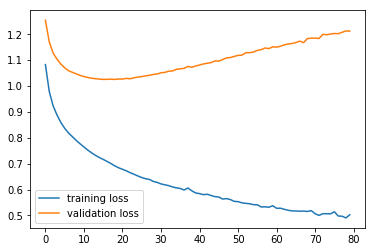

training all but layer 2
on epoch 0
	on iteration 14 / 15
	training loss = 0.945676
	validation loss = 1.099191
on epoch 1
	on iteration 14 / 15
	training loss = 0.878429
	validation loss = 1.051296
on epoch 2
	on iteration 14 / 15
	training loss = 0.842431
	validation loss = 1.029637
on epoch 3
	on iteration 14 / 15
	training loss = 0.817756
	validation loss = 1.017810
on epoch 4
	on iteration 14 / 15
	training loss = 0.798406
	validation loss = 1.010507
on epoch 5
	on iteration 14 / 15
	training loss = 0.782017
	validation loss = 1.004611
on epoch 6
	on iteration 14 / 15
	training loss = 0.767719
	validation loss = 1.000648
on epoch 7
	on iteration 14 / 15
	training loss = 0.755161
	validation loss = 0.997956
on epoch 8
	on iteration 14 / 15
	training loss = 0.743824
	validation loss = 0.996699
on epoch 9
	on iteration 14 / 15
	training loss = 0.733282
	validation loss = 0.995742
on epoch 10
	on iteration 14 / 15
	training loss = 0.723455
	validation loss = 0.995451
on epoch 11
	on i

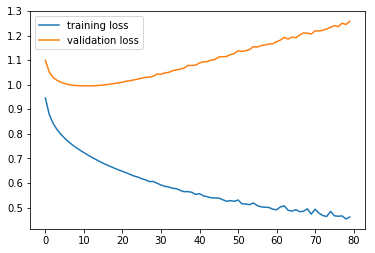

In [48]:
epochs = 80
layers = [0, 1, 2]
gt_losses_nodropout_1l = np.zeros((len(layers), epochs))
gv_losses_nodropout_1l = np.zeros((len(layers), epochs))
for l, enabled_layer in enumerate(layers):
    print('training layer %d' % l)
    gutenberg_model = BeatlesLSTM(64, 3)
    gutenberg_model.load_state_dict(torch.load('model_checkpoint_3_h64_3layer_epoch40'))
    # no dropout here

    gt_losses_nodropout_1l[l], gv_losses_nodropout_1l[l] = train_loop(gutenberg_model, epochs, train_data_ix, train_data_array,
                                                                val_data_ix, val_data_array,
                                                    optimizer=optim.RMSprop(layer_params_and_last(gutenberg_model, l)))
    
    ts = np.arange(epochs)
    print('min val_loss is %f, after epoch %d' % (np.min(gv_losses_nodropout_1l[l]), np.argmin(gv_losses_nodropout_1l[l])))
    plt.plot(ts, gt_losses_nodropout_1l[l], label='training loss')
    plt.plot(ts, gv_losses_nodropout_1l[l], label='validation loss')
    plt.legend(loc='best')
    plt.show()

training all but layer 0
on epoch 0
	on iteration 14 / 15
	training loss = 12.572530
	validation loss = 11.595247
on epoch 1
	on iteration 14 / 15
	training loss = 9.358305
	validation loss = 8.772003
on epoch 2
	on iteration 14 / 15
	training loss = 2.225785
	validation loss = 2.261281
on epoch 3
	on iteration 14 / 15
	training loss = 1.119451
	validation loss = 1.253004
on epoch 4
	on iteration 14 / 15
	training loss = 1.072475
	validation loss = 1.200060
on epoch 5
	on iteration 14 / 15
	training loss = 1.043681
	validation loss = 1.171244
on epoch 6
	on iteration 14 / 15
	training loss = 1.024599
	validation loss = 1.150754
on epoch 7
	on iteration 14 / 15
	training loss = 1.008331
	validation loss = 1.133686
on epoch 8
	on iteration 14 / 15
	training loss = 0.995896
	validation loss = 1.121500
on epoch 9
	on iteration 14 / 15
	training loss = 0.986409
	validation loss = 1.112255
on epoch 10
	on iteration 14 / 15
	training loss = 0.978894
	validation loss = 1.104461
on epoch 11
	on

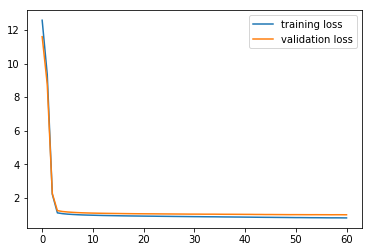

training all but layer 1
on epoch 0
	on iteration 14 / 15
	training loss = 1.102640
	validation loss = 1.241467
on epoch 1
	on iteration 14 / 15
	training loss = 1.041760
	validation loss = 1.176113
on epoch 2
	on iteration 14 / 15
	training loss = 1.006784
	validation loss = 1.142661
on epoch 3
	on iteration 14 / 15
	training loss = 0.985572
	validation loss = 1.119035
on epoch 4
	on iteration 14 / 15
	training loss = 0.969628
	validation loss = 1.104828
on epoch 5
	on iteration 14 / 15
	training loss = 0.958361
	validation loss = 1.093586
on epoch 6
	on iteration 14 / 15
	training loss = 0.947481
	validation loss = 1.083474
on epoch 7
	on iteration 14 / 15
	training loss = 0.937022
	validation loss = 1.072995
on epoch 8
	on iteration 14 / 15
	training loss = 0.928624
	validation loss = 1.063697
on epoch 9
	on iteration 14 / 15
	training loss = 0.921452
	validation loss = 1.058305
on epoch 10
	on iteration 14 / 15
	training loss = 0.916106
	validation loss = 1.054263
on epoch 11
	on i

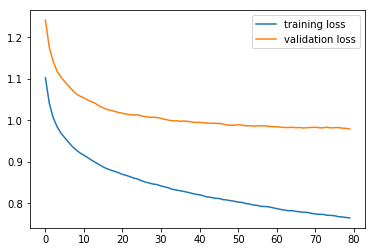

training all but layer 2
on epoch 0
	on iteration 14 / 15
	training loss = 1.058426
	validation loss = 1.184458
on epoch 1
	on iteration 14 / 15
	training loss = 1.015678
	validation loss = 1.140263
on epoch 2
	on iteration 14 / 15
	training loss = 0.988959
	validation loss = 1.112372
on epoch 3
	on iteration 14 / 15
	training loss = 0.968890
	validation loss = 1.092408
on epoch 4
	on iteration 14 / 15
	training loss = 0.953771
	validation loss = 1.078413
on epoch 5
	on iteration 14 / 15
	training loss = 0.942253
	validation loss = 1.069450
on epoch 6
	on iteration 14 / 15
	training loss = 0.932678
	validation loss = 1.060897
on epoch 7
	on iteration 14 / 15
	training loss = 0.924577
	validation loss = 1.052939
on epoch 8
	on iteration 14 / 15
	training loss = 0.918139
	validation loss = 1.047995
on epoch 9
	on iteration 14 / 15
	training loss = 0.912120
	validation loss = 1.043594
on epoch 10
	on iteration 14 / 15
	training loss = 0.908030
	validation loss = 1.040624
on epoch 11
	on i

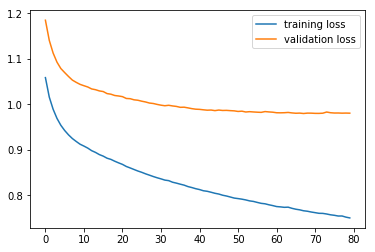

In [51]:
epochs = 80
layers = [0, 1, 2]
gt_losses_1l = np.zeros((len(layers), epochs))
gv_losses_1l = np.zeros((len(layers), epochs))
for l, enabled_layer in enumerate(layers):
    print('training layer %d' % l)
    gutenberg_model = BeatlesLSTM(64, 3)
    gutenberg_model.load_state_dict(torch.load('model_checkpoint_3_h64_3layer_epoch40'))
    gutenberg_model.lstm.dropout = 0.2

    gt_losses_1l[l], gv_losses_1l[l] = train_loop(gutenberg_model, epochs, train_data_ix, train_data_array,
                                                                val_data_ix, val_data_array,
                                                    optimizer=optim.RMSprop(layer_params_and_last(gutenberg_model, l)))
    
    ts = np.arange(epochs)
    print('min val_loss is %f, after epoch %d' % (np.min(gv_losses_1l[l]), np.argmin(gv_losses_1l[l])))
    plt.plot(ts, gt_losses_1l[l], label='training loss')
    plt.plot(ts, gv_losses_1l[l], label='validation loss')
    plt.legend(loc='best')
    plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 2.032823
	validation loss = 2.155854
on epoch 1
	on iteration 14 / 15
	training loss = 1.626798
	validation loss = 1.781744
on epoch 2
	on iteration 14 / 15
	training loss = 1.271204
	validation loss = 1.397018
on epoch 3
	on iteration 14 / 15
	training loss = 1.170180
	validation loss = 1.293801
on epoch 4
	on iteration 14 / 15
	training loss = 1.119799
	validation loss = 1.239029
on epoch 5
	on iteration 14 / 15
	training loss = 1.088351
	validation loss = 1.212669
on epoch 6
	on iteration 14 / 15
	training loss = 1.045745
	validation loss = 1.169265
on epoch 7
	on iteration 14 / 15
	training loss = 1.019204
	validation loss = 1.146693
on epoch 8
	on iteration 14 / 15
	training loss = 0.997360
	validation loss = 1.127026
on epoch 9
	on iteration 14 / 15
	training loss = 0.980056
	validation loss = 1.114606
on epoch 10
	on iteration 14 / 15
	training loss = 0.961726
	validation loss = 1.100636
on epoch 11
	on iteration 14 / 15
	trainin

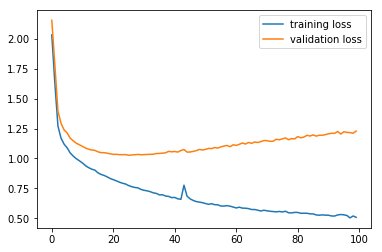

on epoch 0
	on iteration 14 / 15
	training loss = 2.317505
	validation loss = 2.508840
on epoch 1
	on iteration 14 / 15
	training loss = 2.264083
	validation loss = 2.435805
on epoch 2
	on iteration 14 / 15
	training loss = 2.531148
	validation loss = 2.640087
on epoch 3
	on iteration 14 / 15
	training loss = 2.151304
	validation loss = 2.310734
on epoch 4
	on iteration 14 / 15
	training loss = 1.601551
	validation loss = 1.760610
on epoch 5
	on iteration 14 / 15
	training loss = 1.564703
	validation loss = 1.720472
on epoch 6
	on iteration 14 / 15
	training loss = 1.503136
	validation loss = 1.650919
on epoch 7
	on iteration 14 / 15
	training loss = 1.441583
	validation loss = 1.583103
on epoch 8
	on iteration 14 / 15
	training loss = 1.400141
	validation loss = 1.538993
on epoch 9
	on iteration 14 / 15
	training loss = 1.336767
	validation loss = 1.472117
on epoch 10
	on iteration 14 / 15
	training loss = 1.288506
	validation loss = 1.423674
on epoch 11
	on iteration 14 / 15
	trainin

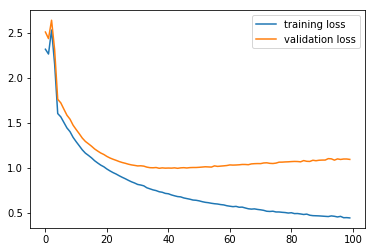

on epoch 0
	on iteration 14 / 15
	training loss = 2.269698
	validation loss = 2.443218
on epoch 1
	on iteration 14 / 15
	training loss = 2.267279
	validation loss = 2.450961
on epoch 2
	on iteration 14 / 15
	training loss = 2.220295
	validation loss = 2.385560
on epoch 3
	on iteration 14 / 15
	training loss = 2.148806
	validation loss = 2.329674
on epoch 4
	on iteration 14 / 15
	training loss = 2.070253
	validation loss = 2.254441
on epoch 5
	on iteration 14 / 15
	training loss = 2.002665
	validation loss = 2.184605
on epoch 6
	on iteration 14 / 15
	training loss = 2.010509
	validation loss = 2.213060
on epoch 7
	on iteration 14 / 15
	training loss = 1.929001
	validation loss = 2.136834
on epoch 8
	on iteration 14 / 15
	training loss = 1.899246
	validation loss = 2.098839
on epoch 9
	on iteration 14 / 15
	training loss = 1.898453
	validation loss = 2.122300
on epoch 10
	on iteration 14 / 15
	training loss = 1.887836
	validation loss = 2.118279
on epoch 11
	on iteration 14 / 15
	trainin

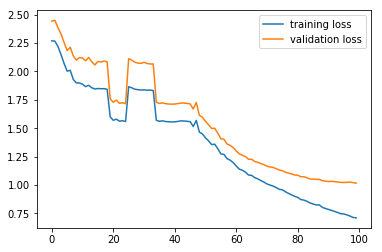

In [86]:


for epoch in range(100):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_1h_dropout += [train_loss]
    val_losses_1h_dropout += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_1layer_dropout_mb4_epoch' + str(epoch))

ts = np.arange(100)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_1h), np.argmin(val_losses_1h)))
plt.plot(ts, train_losses_1h_dropout, label='training loss')
plt.plot(ts, val_losses_1h_dropout, label='validation loss')
plt.legend(loc='best')
plt.show()

#######################################

model = BeatlesLSTM(64, 2)
model.lstm.dropout = 0.2
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_2h_dropout = []
val_losses_2h_dropout = []
minibatch_size = 4

for epoch in range(100):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_2h_dropout += [train_loss]
    val_losses_2h_dropout += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_2layer_dropout_mb4_epoch' + str(epoch))

ts = np.arange(100)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_2h), np.argmin(val_losses_2h)))
plt.plot(ts, train_losses_2h_dropout, label='training loss')
plt.plot(ts, val_losses_2h_dropout, label='validation loss')
plt.legend(loc='best')
plt.show()

########################################

model = BeatlesLSTM(64, 3)
model.lstm.dropout = 0.2
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_3h_dropout = []
val_losses_3h_dropout = []
minibatch_size = 4

for epoch in range(100):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_3h_dropout += [train_loss]
    val_losses_3h_dropout += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_3layer_dropout_mb4_epoch' + str(epoch))

ts = np.arange(100)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_3h), np.argmin(val_losses_3h)))
plt.plot(ts, train_losses_3h_dropout, label='training loss')
plt.plot(ts, val_losses_3h_dropout, label='validation loss')
plt.legend(loc='best')
plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 2.267184
	validation loss = 2.438525
on epoch 1
	on iteration 14 / 15
	training loss = 2.261115
	validation loss = 2.431079
on epoch 2
	on iteration 14 / 15
	training loss = 2.248105
	validation loss = 2.414086
on epoch 3
	on iteration 14 / 15
	training loss = 2.254474
	validation loss = 2.423222
on epoch 4
	on iteration 14 / 15
	training loss = 2.398250
	validation loss = 2.620334
on epoch 5
	on iteration 14 / 15
	training loss = 2.259781
	validation loss = 2.425845
on epoch 6
	on iteration 14 / 15
	training loss = 2.254587
	validation loss = 2.425535
on epoch 7
	on iteration 14 / 15
	training loss = 1.613242
	validation loss = 1.771025
on epoch 8
	on iteration 14 / 15
	training loss = 1.581174
	validation loss = 1.767301
on epoch 9
	on iteration 14 / 15
	training loss = 1.567174
	validation loss = 1.723370
on epoch 10
	on iteration 14 / 15
	training loss = 1.551507
	validation loss = 1.706267
on epoch 11
	on iteration 14 / 15
	trainin

	on iteration 14 / 15
	training loss = 0.505220
	validation loss = 1.349303
on epoch 186
	on iteration 14 / 15
	training loss = 0.505909
	validation loss = 1.336979
on epoch 187
	on iteration 14 / 15
	training loss = 0.501727
	validation loss = 1.366570
on epoch 188
	on iteration 14 / 15
	training loss = 0.501023
	validation loss = 1.345570
on epoch 189
	on iteration 14 / 15
	training loss = 0.501371
	validation loss = 1.367195
on epoch 190
	on iteration 14 / 15
	training loss = 0.506346
	validation loss = 1.352682
on epoch 191
	on iteration 14 / 15
	training loss = 0.492062
	validation loss = 1.366562
on epoch 192
	on iteration 14 / 15
	training loss = 0.489767
	validation loss = 1.358472
on epoch 193
	on iteration 14 / 15
	training loss = 0.524931
	validation loss = 1.374461
on epoch 194
	on iteration 14 / 15
	training loss = 0.526192
	validation loss = 1.387042
on epoch 195
	on iteration 14 / 15
	training loss = 0.487958
	validation loss = 1.368690
on epoch 196
	on iteration 14 / 15

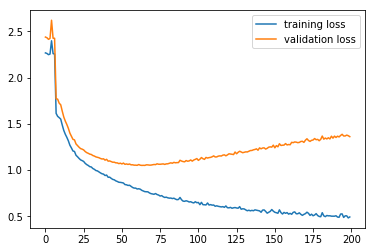

on epoch 0
	on iteration 14 / 15
	training loss = 2.272050
	validation loss = 2.447581
on epoch 1
	on iteration 14 / 15
	training loss = 2.259292
	validation loss = 2.432505
on epoch 2
	on iteration 14 / 15
	training loss = 2.221035
	validation loss = 2.372898
on epoch 3
	on iteration 14 / 15
	training loss = 2.324769
	validation loss = 2.528704
on epoch 4
	on iteration 14 / 15
	training loss = 1.666363
	validation loss = 1.825248
on epoch 5
	on iteration 14 / 15
	training loss = 1.596335
	validation loss = 1.753786
on epoch 6
	on iteration 14 / 15
	training loss = 1.561754
	validation loss = 1.717473
on epoch 7
	on iteration 14 / 15
	training loss = 1.500441
	validation loss = 1.651399
on epoch 8
	on iteration 14 / 15
	training loss = 3.273242
	validation loss = 3.272905
on epoch 9
	on iteration 14 / 15
	training loss = 1.533639
	validation loss = 1.686919
on epoch 10
	on iteration 14 / 15
	training loss = 1.446497
	validation loss = 1.592998
on epoch 11
	on iteration 14 / 15
	trainin

	on iteration 14 / 15
	training loss = 0.274836
	validation loss = 1.843447
on epoch 186
	on iteration 14 / 15
	training loss = 0.300762
	validation loss = 1.759373
on epoch 187
	on iteration 14 / 15
	training loss = 0.295800
	validation loss = 1.743596
on epoch 188
	on iteration 14 / 15
	training loss = 0.231364
	validation loss = 1.786656
on epoch 189
	on iteration 14 / 15
	training loss = 0.256015
	validation loss = 1.780469
on epoch 190
	on iteration 14 / 15
	training loss = 0.245000
	validation loss = 1.798954
on epoch 191
	on iteration 14 / 15
	training loss = 0.284667
	validation loss = 1.818078
on epoch 192
	on iteration 14 / 15
	training loss = 0.322807
	validation loss = 1.774171
on epoch 193
	on iteration 14 / 15
	training loss = 0.255936
	validation loss = 1.785370
on epoch 194
	on iteration 14 / 15
	training loss = 0.221774
	validation loss = 1.790773
on epoch 195
	on iteration 14 / 15
	training loss = 0.214051
	validation loss = 1.829525
on epoch 196
	on iteration 14 / 15

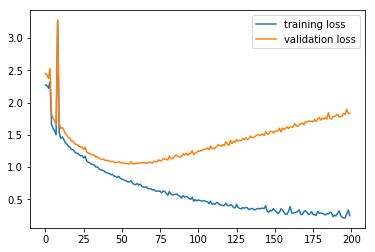

In [81]:
# the 3-deep stacks looked like they could have used some more training. Let's train them for 200 epochs.

model = BeatlesLSTM(32, 3)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_3h_32 = []
val_losses_3h_32 = []
minibatch_size = 4

for epoch in range(200):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_3h_32 += [train_loss]
    val_losses_3h_32 += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h32s_3layer_mb4_epoch' + str(epoch))

ts = np.arange(200)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_3h), np.argmin(val_losses_3h)))
plt.plot(ts, train_losses_3h_32, label='training loss')
plt.plot(ts, val_losses_3h_32, label='validation loss')
plt.legend(loc='best')
plt.show()

######################################

model = BeatlesLSTM(64, 3)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_3h = []
val_losses_3h = []
minibatch_size = 4

for epoch in range(200):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_3h += [train_loss]
    val_losses_3h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_3layer_mb4_epoch' + str(epoch))

ts = np.arange(200)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_3h), np.argmin(val_losses_3h)))
plt.plot(ts, train_losses_3h, label='training loss')
plt.plot(ts, val_losses_3h, label='validation loss')
plt.legend(loc='best')
plt.show()

In [124]:
softmax = torch.nn.Softmax()
chars = range(128)

def sample_char(char_scores, temp):
    char_scores = softmax(char_scores / temp)
    char = np.random.choice(chars, p=char_scores.detach().numpy())
    while not chr(char) in string.printable:# and char != 0:
        char = np.random.choice(chars, p=char_scores.detach().numpy())
    return char

def sample(model, first_char, init_hidden, T, temp):
    model.init_hidden_zeros(1)
    result = first_char
    cur_char = ord(first_char)
    for t in range(T):
        one_hot_char = torch.tensor(i128[cur_char], dtype=torch.float).view(1, 1, -1)
        char_scores = model(one_hot_char)
        cur_char = sample_char(char_scores.view(-1), temp)
        if cur_char == 0:
            return result
        result += chr(cur_char)
    return result


In [125]:
model = BeatlesLSTM(64, 3)
#model.load_state_dict(torch.load('transferred_fromlyrics_dropout_layer1_epoch1'))
model.load_state_dict(torch.load('transferred_dropout_allbutlayer1_epoch69'))

sampled_song = sample(model, 'T', torch.zeros((1, 1, model.hidden_dim)), 1000, 0.3)
print(sampled_song)

/home/alex/bin/anaconda3/envs/cs682/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


The will the love you down the world to she she say a should want)

Well you want to she was to she be it
I down the words to say the world and I want)

I'm on the wisdom and I know I want)

I know I don't be a want to she was to be you can the words of the words of the bean to see
Say the word what I want)

Im on the way you say the will the words to she belonged

I want)

I don't say so should be you know I don't want to let you love it's girl

I the sine

I want)

Well me you know I want)

Hey what I don't get the sand you know I say it be the words and I want)

Im do.

Let the same

Well you know I love you know I'm got the words to so for the sky what I said a roll and so me
I want)

I'm love you know I want)

Well I want)

I want)

I don't can the taxman

I dont want a wanna be you know I don't her me a down the words in the words and I do you know I trould gonna be you can you want to the words to see

Line on the words to see it be you know I want)

I know I want)

I want)

I'm

In [84]:
gutenberg_model = BeatlesLSTM(64, 3)
gutenberg_model.load_state_dict(torch.load('model_checkpoint_2_h64_3layer_epoch50'))
print('loss of best Gutenberg LSTM on Beatles validation data is %f' % model_loss(gutenberg_model, loss_func, val_data_ix, val_data_array))

minibatch_size = 4

loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(gutenberg_model.parameters())

for epoch in range(200):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        gutenberg_model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        gutenberg_model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = gutenberg_model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(gutenberg_model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(gutenberg_model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(gutenberg_model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    #train_losses_3h += [train_loss]
    #val_losses_3h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_3layer_mb4_epoch' + str(epoch))

loss of best Gutenberg LSTM on Beatles validation data is 11.861580
on epoch 0
	on iteration 14 / 15
	training loss = 1.049871
	validation loss = 1.194293
on epoch 1
	on iteration 14 / 15
	training loss = 0.917023
	validation loss = 1.078366
on epoch 2
	on iteration 14 / 15
	training loss = 0.855619
	validation loss = 1.034004
on epoch 3
	on iteration 14 / 15
	training loss = 0.815328
	validation loss = 1.008193
on epoch 4
	on iteration 14 / 15
	training loss = 0.786037
	validation loss = 0.992822
on epoch 5
	on iteration 14 / 15
	training loss = 0.761784
	validation loss = 0.982182
on epoch 6
	on iteration 14 / 15
	training loss = 0.741227
	validation loss = 0.974579
on epoch 7
	on iteration 14 / 15
	training loss = 0.722647
	validation loss = 0.969144
on epoch 8
	on iteration 14 / 15
	training loss = 0.705638
	validation loss = 0.965375
on epoch 9
	on iteration 14 / 15
	training loss = 0.689736
	validation loss = 0.963225
on epoch 10
	on iteration 14 / 15
	training loss = 0.674946
	v

KeyboardInterrupt: 